## Design considerations
The principle here is to fit a cubic rational bezier determine the chroma curve. We use L-C boundary control points $(0, 0)$, $(100, 0)$, with a single mid-point $(L^*, C_{L^*}^*)$, where $L^*$ is the lightness at which the *maximum, maximum* chroma $C_{L^*}^*$ occurs.

We allow some slight adjustments to this scheme, like shifting the $L^*$ point and changing the weight of the mid-point in the bezier curve (producing sharper, more pointed curves). The general aim is to fit the existing v1.1.1 chroma curves with an explainable continuous model, which of course can be used to generate color points for any reqested lightness levels.

### Future considerations
I like the idea of the **MCL** scheme, not used here. This scheme used a standardized lightness midpoint where chroma was maximized (for each accent), but did not fix the curve itself. So accent chroma curves had different heights, but they rise and fall in the same places along the lightness spectrum. Each step can be seen to make the *same percentage jump* to the maximum, unifying the movements across accents (e.g., if yellow has max chroma of 0.1 and red of 0.4, the chroma value at lightness L is the same x% of each accent's respective chroma max). This was a step in the right direction compared to **UCC**, which used an *identical* chroma curve for all accents. So while **MCL** preserved more color identity, it still had distinct effects like washing out the orange too early. But I *do* like the idea of being able to have unified justification for the chroma curve jumps across all accents, and while **QBR** (below) is a faithful v111 reproduction, the curves are pretty distinct in terms of shape (due to the allowed weighting; some are sharper, some smoother).

We can also constrain by `Lab` distance: at `L60` or so, we could look at `Lab` distance from the grey `L20` reference background and make sure all accents have the same distance (which is basically just trying to get a uniform contrast ratio). We might also look at `Lab` distance *between* accents and make sure that *relative distinction* is preserved as we move across lightness levels.

TODO: symmetry around 45 -- 60, no matter what. Or decide on new distances, but flipping light/dark should have the same contrast. If that doesn't line up with lightness, so be it; need to find either Lab distance or whatever makes that symmetric.

In [1]:
import json
from pathlib import Path
from functools import cache

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, BSpline

from coloraide import Color

@cache
def max_C_Lh(L, h, space='srgb', eps=1e-6, tol=1e-9):
    '''
    Binary search for max chroma at fixed lightness and hue

    Parameters:
        L: lightness percentage
    '''
    def C_in_gamut(C):
        return Color('oklch', [L/100, C, h]).convert(space).in_gamut(tolerance=tol)

    lo, hi = 0.0, 0.1
    while C_in_gamut(hi): hi *= 2
    while hi - lo > eps:
        m = (lo + hi) / 2
        lo, hi = (m, hi) if C_in_gamut(m) else (lo, m)

    Cmax = lo
    c_oklch = Color('oklch', [L, Cmax, h])
    c_srgb  = c_oklch.convert('srgb')
    
    return Cmax

def quad_bezier_rational(P0, P1, P2, w, t):
    t = np.asarray(t)[:, None]
    num = (1-t)**2*P0 + 2*w*(1-t)*t*P1 + t**2*P2
    den = (1-t)**2 + 2*w*(1-t)*t + t**2
    
    return num/den
    
def bezier_y_at_x(P0, P1, P2, w, x_query, n=400):
    t = np.linspace(0, 1, n)
    B = quad_bezier_rational(P0, P1, P2, w, t)
    x_vals, y_vals = B[:, 0], B[:, 1]
    
    return np.interp(x_query, x_vals, y_vals)

In [2]:
# SET LIGHTNESS CONTROL POINTS
# L_points = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 98]
L_points = list(range(10, 98+1))

In [3]:
# FIXED MONOBIOME PARAMETERS
L_resolution = 5  # step size along lightness dim
L_space = np.arange(0, 100+L_resolution, L_resolution)

monotone_C_map = {
    "alpine": 0,
    "badlands": 0.011,
    "chaparral": 0.011,
    "savanna": 0.011,
    "grassland": 0.011,
    "tundra": 0.011,
}

h_weights = {
    "red": 3.5,
    "orange": 3.5,
    "yellow": 0.7,
    "green": 0.95,
    "blue": 1.0,
}
h_offsets = {
    "red": -1,  # -5,
    "orange": 0,  #-2,
    "yellow": 0,
    "green": 0,
    "blue": 0,
}

monotone_h_map = {
    "alpine": 0,
    "badlands": 29,
    "chaparral": 62.5,
    "savanna": 104,
    "grassland": 148,
    "tundra": 262,
}
accent_h_map = {
    "red": 29,
    "orange": 62.5,
    "yellow": 104,
    "green": 148,
    "blue": 262,
}
h_map = {**monotone_h_map, **accent_h_map}

In [4]:
# compute C max values over each point in L space
h_Lspace_Cmax = {
    h_str: [max_C_Lh(_L, _h) for _L in L_space]
    for h_str, _h in h_map.items()
}

In [5]:
# compute *unbounded* chroma curves for all hues
h_L_points_C = {}
h_ctrl_L_C = {}

for h_str, _h in monotone_h_map.items():
    h_L_points_C[h_str] = [monotone_C_map[h_str]]*len(L_points)
    
for h_str, _h in accent_h_map.items():
    Lspace_Cmax = h_Lspace_Cmax[h_str]
    
    # get L value of max chroma; will be a bezier control
    L_Cmax_idx = np.argmax(Lspace_Cmax)
    L_Cmax = L_space[L_Cmax_idx]

    # offset control point by any preset x-shift
    L_Cmax += h_offsets[h_str]

    # and get max C at the L offset
    Cmax = max_C_Lh(L_Cmax, _h)

    # set 3 control points
    p_0 = np.array([0, 0])
    p_Cmax = np.array([L_Cmax, Cmax])
    p_100 = np.array([100, 0])
    
    B_L_points = bezier_y_at_x(p_0, p_Cmax, p_100, h_weights.get(h_str, 1), L_points)
    h_L_points_C[h_str] = B_L_points
    h_ctrl_L_C[h_str] = np.vstack([p_0, p_Cmax, p_100])

In [6]:
# compute full set of final chroma curves
h_LC_color_map = {}
h_L_points_Cstar = {}

for h_str, L_points_C in h_L_points_C.items():
    _h = h_map[h_str]
    h_L_points_Cstar[h_str] = [
        min(_C, max_C_Lh(_L, _h))
        for _L, _C in zip(L_points, L_points_C)
    ]

In [7]:
# put together objects for output formats
toml_lines = []
oklch_hL_dict = {}

for h_str, L_points_Cstar in h_L_points_Cstar.items():
    _h = h_map[h_str]
    toml_lines.append(f"[{h_str}]")
    oklch_hL_dict[h_str] = {}
    
    for _L, _C in zip(L_points, L_points_Cstar):
        oklch = Color('oklch', [_L/100, _C, _h])
        srgb = oklch.convert('srgb')
        
        hex_str = srgb.to_string(hex=True)
        oklch_str = oklch.to_string(percent=False)
        
        toml_lines.append(f'l{_L} = "{hex_str}"')
        oklch_hL_dict[h_str][_L] = oklch_str
        
    toml_lines.append("")

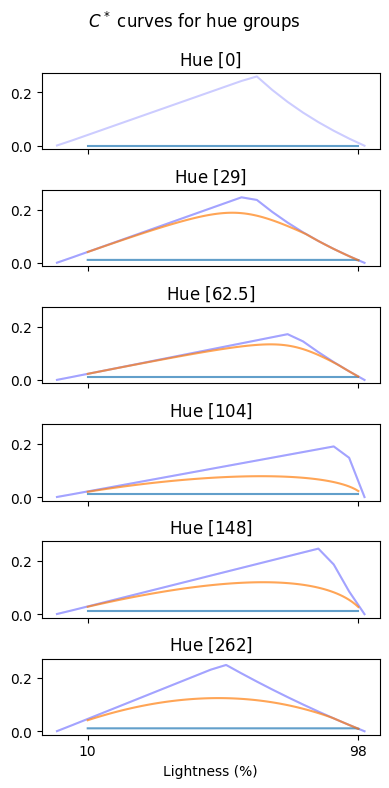

In [8]:
ax_h_map = {}
fig, axes = plt.subplots(
    len(monotone_h_map),
    1,
    sharex=True,
    sharey=True,
    figsize=(4, 8)
)

for i, h_str in enumerate(h_L_points_Cstar):
    _h = h_map[h_str]
    L_points_Cstar = h_L_points_Cstar[h_str]
    L_space_Cmax = h_Lspace_Cmax[h_str]
    
    if _h not in ax_h_map:
        ax_h_map[_h] = axes[i]
    ax = ax_h_map[_h]

    # plot Cmax and Cstar
    ax.plot(L_space, L_space_Cmax, c="b", alpha=0.2)
    ax.plot(L_points, L_points_Cstar, alpha=0.7)
    
    ax.title.set_text(f"Hue [${_h}$]")
    
axes[-1].set_xlabel("Lightness (%)")
axes[-1].set_xticks([L_points[0], L_points[-1]])

fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.suptitle("$C^*$ curves for hue groups")
plt.show()

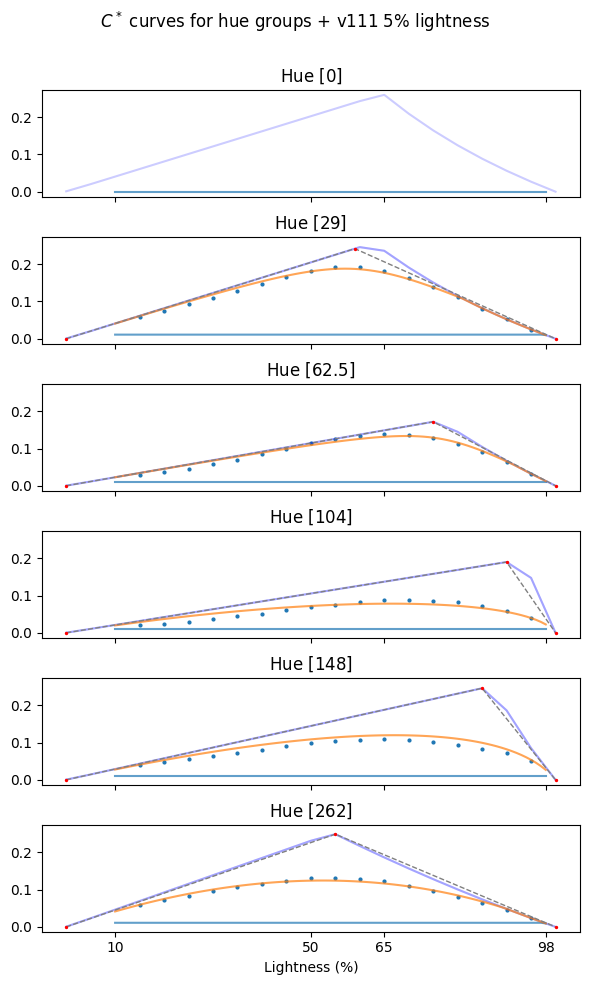

In [9]:
v111_L_space = list(range(15, 95+1, 5))
v111_hC_points = {
    "red": [0.058, 0.074, 0.092, 0.11, 0.128, 0.147, 0.167, 0.183, 0.193, 0.193, 0.182, 0.164, 0.14, 0.112, 0.081, 0.052, 0.024],
    "orange": [0.030, 0.038, 0.046, 0.058, 0.07, 0.084, 0.1, 0.114, 0.125, 0.134, 0.138, 0.136, 0.128, 0.112, 0.092, 0.064, 0.032],
    "yellow": [0.02, 0.024, 0.03, 0.036, 0.044, 0.05, 0.06, 0.068, 0.076, 0.082, 0.088, 0.088, 0.086, 0.082, 0.072, 0.058, 0.04],
    "green": [0.0401, 0.048, 0.056, 0.064, 0.072, 0.08, 0.09, 0.098, 0.104, 0.108, 0.11, 0.108, 0.102, 0.094, 0.084, 0.072, 0.05],
    "blue": [0.06, 0.072, 0.084, 0.096, 0.106, 0.116, 0.124, 0.13, 0.132, 0.128, 0.122, 0.11, 0.096, 0.08, 0.064, 0.044, 0.023],
}

ax_h_map = {}
fig, axes = plt.subplots(
    len(monotone_h_map),
    1,
    sharex=True,
    sharey=True,
    figsize=(6, 10)
)

for i, h_str in enumerate(h_L_points_Cstar):
    _h = h_map[h_str]
    L_points_Cstar = h_L_points_Cstar[h_str]
    L_space_Cmax = h_Lspace_Cmax[h_str]
    
    if _h not in ax_h_map:
        ax_h_map[_h] = axes[i]
    ax = ax_h_map[_h]

    # plot Cmax and Cstar
    ax.plot(L_space, L_space_Cmax, c="b", alpha=0.2)
    ax.plot(L_points, L_points_Cstar, alpha=0.7)

    if h_str in v111_hC_points:
        ax.scatter(v111_L_space, v111_hC_points[h_str], s=4)
        
    if h_str in h_ctrl_L_C:
        cpts = h_ctrl_L_C[h_str]
        cpt_x, cpt_y = cpts[:, 0], cpts[:, 1]
        h_w = h_weights.get(h_str, 1)
        
        P0, P1, P2 = cpts[0], cpts[1], cpts[2]
        d0 = 2 * h_w * (P1 - P0)
        d2 = 2 * h_w * (P2 - P1)

        handle_scale = 0.25
        H0 = P0 + handle_scale * d0
        H2 = P2 - handle_scale * d2
    
        # ax.plot([P0[0], H0[0]], [P0[1], H0[1]], color='tab:blue', lw=1)
        # ax.plot([P2[0], H2[0]], [P2[1], H2[1]], color='tab:orange', lw=1)
        
        ax.plot(cpt_x, cpt_y, '--', color='gray', lw=1, label='control polygon')
        ax.scatter(cpt_x, cpt_y, color='red', zorder=5, s=2)
        
    ax.title.set_text(f"Hue [${_h}$]")
    
axes[-1].set_xlabel("Lightness (%)")
axes[-1].set_xticks([L_points[0], 50, 65, L_points[-1]])

fig.tight_layout()
fig.subplots_adjust(top=0.9)

plt.suptitle("$C^*$ curves for hue groups + v111 5% lightness")
plt.show()

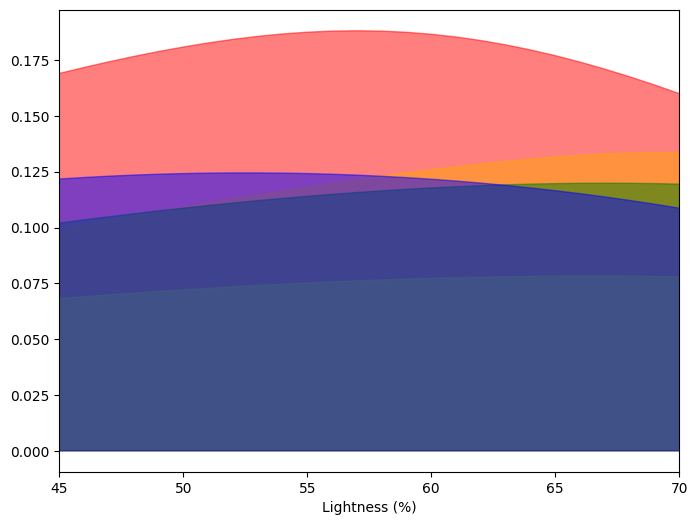

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for h_str in h_L_points_Cstar:
    if h_str not in accent_h_map:
        continue
    ax.fill_between(L_points, h_L_points_Cstar[h_str], alpha=0.5, color=h_str)
    
ax.set_xlabel("Lightness (%)")
ax.set_xticks([L_points[0], 45, 50, 55,   60, 65, 70, L_points[-1]])
ax.set_xlim(45, 70)
fig.show()

In [10]:
# write files -- QBR = "quadratic bezier rational"
PALETTE_DIR = "palettes"

toml_content = '\n'.join(toml_lines)
with Path(PALETTE_DIR, 'monobiome-vQBR.toml').open('w') as f:
    f.write(toml_content)
print("[TOML] written")
    
with Path(PALETTE_DIR, 'monobiome-vQBR-oklch.json').open('w') as f:
    json.dump(oklch_hL_dict, f)
print("[JSON] written")

[TOML] written
[JSON] written
